In [1]:
### PYCHARM ###


import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *


from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch


path = "dataset_CIFAR10"


In [ ]:
### COLAB ###

"""
from google.colab import drive
drive.mount('/content/drive')


! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.callback.fp16 import *
import torch
from fastai.vision.transforms import *
"""


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#check if cuda is available
torch.cuda.is_available()


True

In [4]:
#with maximum batch size

dls = ImageDataLoaders.from_folder(
    path=path,
    train='train',
    valid='validation',
    device = torch.device('cuda'),
    seed=42,
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    batch = 1024)

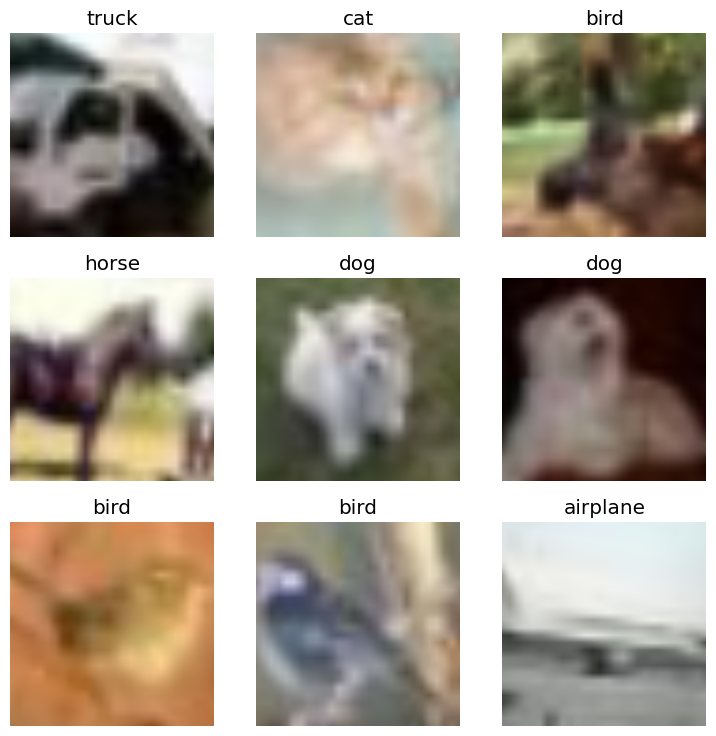

In [ ]:
dls.show_batch()


Fins ara havíem fet tot el conjunt de proves amb la funció fine_tune. Què passa si anem modificant nosaltres mateixos la learning rate fent servir la funció fit_one_cycle?


Comencem, doncs, buscant la learning rate més adequada: 

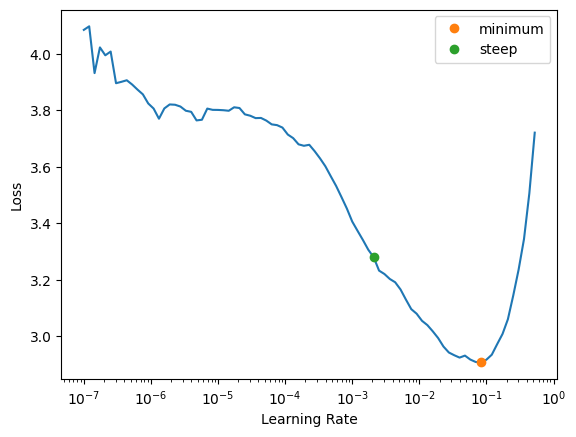

In [5]:
learn = vision_learner(dls, resnet152, metrics=[accuracy, error_rate]).to_fp16()
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [6]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")


Minimum/10: 8.32e-03, steepest point: 2.09e-03



Veiem a partir de la gràfica tres zones diferents:


*   La primera fase, fins a 1e-4, la xarxa no està aprenent (la loss es manté relativament estable)
*   Segona fase, en una learning rate d'entre 1e-4 i 1, la xarxa està aprenent, essent el punt de màxima pendent d'aquesta zona la learning rate adequada (en la qual aprèn més ràpid), que aproximadament és 2e-3
*   La tercera fase, a partir de learning rate 1, aquesta és massa gran i la xarxa ja no aprèn


Agafant la learning rate de 2e-3, comencem a entrenar (només la última capa, les altres estan congelades):

In [7]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate]).to_fp16()
learn.fit_one_cycle(3, lr_max=2e-3)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.899368,0.689982,0.761000,0.239000,01:23
1,0.644348,0.483152,0.828700,0.171300,01:22
2,0.558782,0.452409,0.838100,0.161900,01:22


Ara descongelem la xarxa, i busquem altra vegada la learning rate més adequada per entrenar la xarxa amb totes les capes:

SuggestedLRs(valley=2.75422871709452e-06)

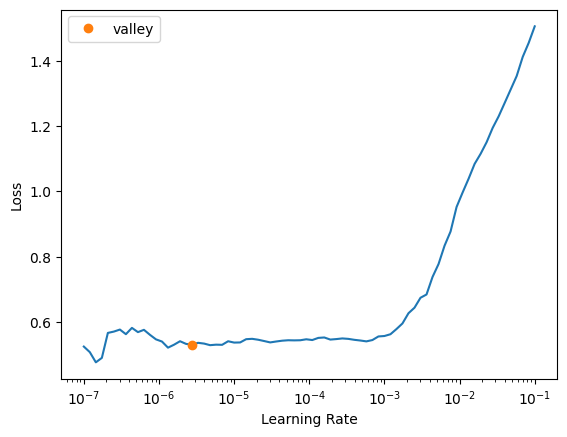

In [8]:
learn.unfreeze()
learn.lr_find()

L'escenari que veiem aquí és diferent: com que la xarxa ja ha entrenat, ja no tenim un descens de la funció de pèrdua tant exagerat com teníem abans. Provarem, doncs, d'entrenar la xarxa sencera amb la learning rate proposada:

In [9]:
learn.fit_one_cycle(6, lr_max=2.75e-6)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.538920,0.455054,0.839700,0.160300,01:32
1,0.528333,0.430361,0.848000,0.152000,01:33
2,0.493156,0.432510,0.848000,0.152000,01:33
3,0.516591,0.421610,0.851400,0.148600,01:31
4,0.496894,0.418449,0.851900,0.148100,01:32
5,0.474881,0.422307,0.852300,0.147700,01:32


Fent això, veiem que arribem a un 0.85 d'accuracy.

Ara podem provar el **learning rate dicriminatiu**. Com que les primeres capes aprenen característiques més generals que les últimes, forcem que aprenguin a un learning rate més baix (ja han après a l'entrenament original) i anem augmentant el learning rate a les últimes capes

In [10]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate]).to_fp16()
learn.fit_one_cycle(3, 2e-3)
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-3))


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.554055,0.429941,0.848600,0.151400,01:32
1,0.490710,0.414024,0.854000,0.146000,01:32
2,0.408142,0.364824,0.875200,0.124800,01:32
3,0.341170,0.353154,0.879600,0.120400,01:33
4,0.310546,0.329736,0.887500,0.112500,01:32
5,0.302348,0.313753,0.891500,0.108500,01:32


Veiem que d'aquesta manera el resultat millora considerablement (passant d'un 0.85 a 0.89). Tot i això, el resultat està lluny encara del 94% d'accuracy que havíem obtingut aplicant la funció fine_tune (que al final no deixa d'aplicar també un learning rate discriminatiu).